# Results

In [2]:
import os
from pathlib import Path
import time
from datetime import datetime
import itertools

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import matplotlib.ticker as mtick
import seaborn as sns
from sklearn.model_selection import KFold, RepeatedStratifiedKFold
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import model_from_json

In [3]:
sns.set(style = 'whitegrid')
colors = sns.color_palette()
colorsp1 = colors
colorsp1.pop(0)
colorsp1.append(colors[0])

def format_plot(ax, plt):
    ax.set_ylabel('validation accuracy')
    plt.ylim(bottom=0.35, top=1.05)
    ax.yaxis.set_major_formatter(FuncFormatter('{0:.0%}'.format))
    ax.set_xlabel('Dataset')
    plt.tight_layout()
    
def print_stats(data, name):
    print(name,  ':')
    print('Quantiles:\n', data['val_acc'].quantile([0.25, 0.5, 0.75]) )
    print('Mean:', data['val_acc'].mean())
    
def print_means(data, names):
    print('Mean averages:')
    for d, n, in zip(data, names):
        print(d['val_acc'].mean(), n)
        

def plot_confusion_matrix(cm, title='Normalised confusion matrix', name=''):
    ''' Plot the normalised confusion matrix
    Parameters
    cm : array - normalised confusion matrix
    Scikit-learn: Machine Learning in Python, Pedregosa et al., JMLR 12, pp. 2825-2830, 2011.
    'Confusion Matrix' https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
    '''
    classes = ['Positive', 'Negative']
    cmap=plt.cm.Blues
    sns.set_style('dark')
    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar(format=FuncFormatter('{0:.0%}'.format))
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.clim(0, 1)
    fmt = '.0%'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True class')
    plt.xlabel('Predicted class')
    plt.tight_layout()
    file_name = 'cm_devnet_'+name+'.png'
    plt.savefig(file_name, bbox_inches='tight')
    sns.set(style = 'whitegrid')
    
    
    
def plot_acc(accuracy_results, result_names, title, image_filename, ylabel='validation accuracy', ylim=[0.3, 1.05]):
    ''' Show a box plot of accuracy data and save image to file'''
    ax = sns.boxplot(data=accuracy_results)
    ax = sns.swarmplot(data=accuracy_results, color='black')
    title = title
    plt.suptitle(title)
    xticks = list(range(len(result_names)))
    plt.xticks(xticks, result_names)
    format_plot(ax, plt)
    ax.set_xlabel('Model')
    ax.set_ylabel(ylabel)
    plt.ylim(bottom=ylim[0], top=ylim[1])
    plt.savefig(image_filename, bbox_inches='tight')
    return ax, plt

In [4]:
def readucr(filename):
    data = np.loadtxt(Path(filename))
    Y = data[:,0]
    X = data[:,1:]
    return X, Y


def dataset_size(filename):
    if 'private_dog0' == filename or 'private_dog1' == filename or 'private_dog2' == filename:
        fdir = '../../data/private_data/private_events_dev' 
    elif 'private' in filename:
        fdir = '../../data/private_data/private_events_dev2' 
        
    _, y_train = readucr(fdir+'/'+filename+'/'+filename+'_TRAIN.txt')
    _, y_test = readucr(fdir+'/'+filename+'/'+filename+'_TEST.txt')
    return y_train.shape[0]+y_test.shape[0]


def end_test_dataset_size(filename):
    fdir = '../../data/private_data/private_events_dev2' 
    _, y_endtest = readucr(fdir+'/'+filename+'/'+filename+'_END_TEST.txt')
    return y_endtest.shape[0]


def sample_sizes(num_dataset, k, m, brackets=True):
    ''' Given a dataset size, calculate the number of samples used in the calculations of m iterations
    of k-fold cross validation.
    Returns 
    ND 
        number of data samples used to calculate the validation accuracy 
    NT
        number of tests used run
    num_text 
        a string that can be used in plots to write ND and NT with subscripts
    '''
    N = num_dataset
    ND = str(round(N/k))
    NT = str(k*m)
    if brackets:
        num_text = '($N_D$='+ND+', $N_T$='+NT+')'
    else:
        num_text = '$N_D$='+ND+', $N_T$='+NT
    return ND, NT, num_text

# Example confusion matrix and box plot

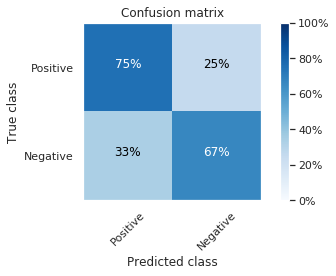

In [5]:
y_true = [1, 1, 1, 1, 0, 0, 0, 0, 0, 0]
y_pred = [1, 1, 0, 1, 0, 0, 0, 1, 1, 0]
cm = confusion_matrix(y_true, y_pred, labels=[1,0])
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
title = 'Confusion matrix' # ($N_D$=10)'
plot_confusion_matrix(cm_norm, title=title, name='example')

          0
0  0.933333
1  0.933333
2  0.866667
3  0.866667
4  0.800000
5  0.800000
6  0.666667
7  0.666667
8  0.666667
9  0.600000
mean 0.78 std 0.12191881532751293
quantiles 0.25    0.666667
0.50    0.800000
0.75    0.866667
Name: 0, dtype: float64


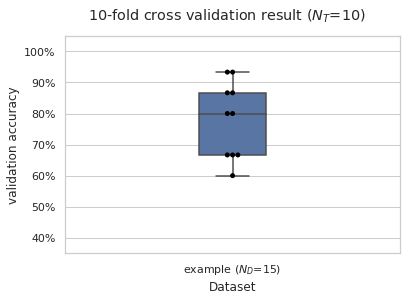

In [6]:
all_data = pd.DataFrame([14, 14, 13, 13, 12, 12, 10, 10, 10, 9])
all_data = all_data/15
print(all_data)
print('mean', all_data[0].mean(), 'std', all_data[0].std())
print('quantiles', all_data[0].quantile([0.25, 0.5, 0.75]))

ax = sns.boxplot(data=all_data, width=0.2)
ax = sns.swarmplot(data=all_data, color='black')
title = '10-fold cross validation result ($N_T$=10)'
plt.suptitle(title)
ax.set_ylabel('validation accuracy')
plt.ylim(bottom=0.35, top=1.05)
ax.yaxis.set_major_formatter(FuncFormatter('{0:.0%}'.format))
ax.set_xlabel('Dataset')
plt.xticks([0], ['example ($N_D$=15)'])
plt.savefig('boxplot_example.png', bbox_inches='tight')

# Confirm performance of untuned DNNs : GunPoint

In [7]:
print('Single train and test. Same train:test split as UCR TSC archive. Reporting validation accuracy and error.', '\n')

print('1-NN (1-nearest neighbor)')
print('0.9133333333333333')
print(1-0.9133333333333333, 'error\n')

file = '../../logs/2019-05-10T20:18/GunPoint/mlpwang_summary.csv'
data1 = pd.read_csv(file, header=None, names=['run','loss','val_acc','epoch','time'])
print(file, '(MLP Wang)')
print('No. results:', data1.shape[0])
print(data1.iloc[0]['val_acc'].mean())
print(1-data1['val_acc'].mean(), 'error\n')

file = '../../logs/2019-03-31T18:07/GunPoint/devnet_summary.csv'
data2 = pd.read_csv(file, header=None, names=['run','loss','val_acc','epoch','time'])
print(file, '(FCN Wang)')
print('No. results:', data2.shape[0])
print(data2['val_acc'].mean())
print(1-data2['val_acc'].mean(), 'error\n')

file = '../../logs/2019-03-29T15:29/GunPoint/devnet_summary.csv'
#file = '../../logs/2019-05-11T13:42/GunPoint/resnet_summary.csv'
data2 = pd.read_csv(file, header=None, names=['run','loss','val_acc','epoch','time'])
print(file, '(ResNet Wang)')
print('No. results:', data2.shape[0])
print(data2['val_acc'].mean())
print(1-data2['val_acc'].mean(), 'error\n')


Single train and test. Same train:test split as UCR TSC archive. Reporting validation accuracy and error. 

1-NN (1-nearest neighbor)
0.9133333333333333
0.08666666666666667 error

../../logs/2019-05-10T20:18/GunPoint/mlpwang_summary.csv (MLP Wang)
No. results: 1
0.9333333373069764
0.06666666269302357 error

../../logs/2019-03-31T18:07/GunPoint/devnet_summary.csv (FCN Wang)
No. results: 1
1.0
0.0 error

../../logs/2019-03-29T15:29/GunPoint/devnet_summary.csv (ResNet Wang)
No. results: 1
0.993333339691162
0.006666660308838002 error



In [8]:
# 10-fold cross validation
ND, NT, num_text = sample_sizes(200, k=10, m=1)
print(num_text, '\n')

print('1-NN (1-nearest neighbor)')
print(0.9450000000000001)
print(0.043779751788545644, '\n')

file = '../../logs/2019-03-17T16:35/GunPoint/mlpwang_summary.csv'
data1 = pd.read_csv(file, header=None, names=['run','loss','val_acc','epoch','time'])
name1 = 'GunPoint'
print(file, '(MLP Wang)')
print(data1['val_acc'].mean())
print(data1['val_acc'].std())
print('Number of folds', data1['val_acc'].count(), '\n')

file = '../../logs/2019-05-09T09:25/GunPoint/devnet_summary.csv'
data2 = pd.read_csv(file, header=None, names=['run','loss','val_acc','epoch','time'])
print(file, '(FCN Wang)')
print(data2['val_acc'].mean())
print(data2['val_acc'].std())
print('Number of folds', data2['val_acc'].count(), '\n')

file = '../../logs/2019-03-18T17:32/GunPoint/resnet_summary.csv'
data2 = pd.read_csv(file, header=None, names=['run','loss','val_acc','epoch','time'])
print(file, '(ResNet Wang)')
print(data2['val_acc'].mean())
print(data2['val_acc'].std())
print('Number of folds', data2['val_acc'].count(), '\n')

($N_D$=20, $N_T$=10) 

1-NN (1-nearest neighbor)
0.9450000000000001
0.043779751788545644 

../../logs/2019-03-17T16:35/GunPoint/mlpwang_summary.csv (MLP Wang)
0.9649999976158142
0.05296749352309429
Number of folds 10 

../../logs/2019-05-09T09:25/GunPoint/devnet_summary.csv (FCN Wang)
1.0
0.0
Number of folds 10 

../../logs/2019-03-18T17:32/GunPoint/resnet_summary.csv (ResNet Wang)
0.9949999988079071
0.015811392070570664
Number of folds 10 



# Untuned models : all dogs data (balanced dataset)

[['1-NN', 0.6024193548387097, 0.0433121162604792], ['MLP', 0.6248848021030426, 0.06573279448330743], ['FCN', 0.6070060521364212, 0.06595959534671478], ['ResNet', 0.6538658618927002, 0.06358524472315732]]


(<matplotlib.axes._subplots.AxesSubplot at 0x7f551d84ca58>,
 <module 'matplotlib.pyplot' from '/usr/local/lib/python3.5/dist-packages/matplotlib/pyplot.py'>)

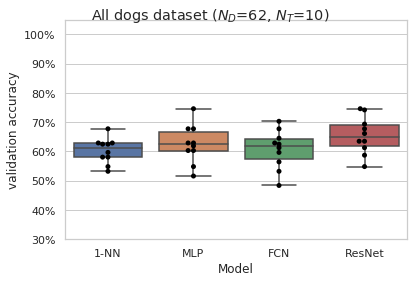

In [9]:
all_data = list()
all_names = list()
results = []
N = dataset_size('private_balanced')
ND, NT, num_text = sample_sizes(N, k=10, m=1)

file = '../../logs/2019-05-10T16:36/private_balanced/nearestneighbours_summary.csv'
data = pd.read_csv(file, header=None, names=['val_acc'])
all_data.append(data['val_acc'])
all_names.append('1-NN')
results.append([all_names[-1], all_data[-1].mean(), all_data[-1].std()])

file = '../../logs/2019-03-21T14:23/private_balanced/mlpwang_summary.csv'
data = pd.read_csv(file, header=None, names=['run','loss','val_acc','epoch','time'])
all_data.append(data['val_acc'])
all_names.append('MLP')
results.append([all_names[-1], all_data[-1].mean(), all_data[-1].std()])

file = '../../logs/2019-05-09T12:30/private_balanced/devnet_summary.csv'
data = pd.read_csv(file, header=None, names=['run','loss','val_acc','epoch','time'])
all_data.append(data['val_acc'])
all_names.append('FCN')
results.append([all_names[-1], all_data[-1].mean(), all_data[-1].std()])

file = '../../logs/2019-03-20T19:47/private_balanced/resnet_summary.csv'
data = pd.read_csv(file, header=None, names=['run','loss','val_acc','epoch','time'])
all_data.append(data['val_acc'])
all_names.append('ResNet')
results.append([all_names[-1], all_data[-1].mean(), all_data[-1].std()])

print(results)
plot_acc(all_data, all_names, 'All dogs dataset '+num_text, 'pubmodels_alldogs.png')

# Untuned models : all dogs correct data (balanced dataset)

[['1-NN', 0.7247619047619047, 0.08343682160652117], ['MLP', 0.7659389774004618, 0.03693851593866594], ['FCN', 0.6786347478628159, 0.0887749548564865], ['ResNet', 0.7243646482626597, 0.04171865928977236]]


(<matplotlib.axes._subplots.AxesSubplot at 0x7f551e04e438>,
 <module 'matplotlib.pyplot' from '/usr/local/lib/python3.5/dist-packages/matplotlib/pyplot.py'>)

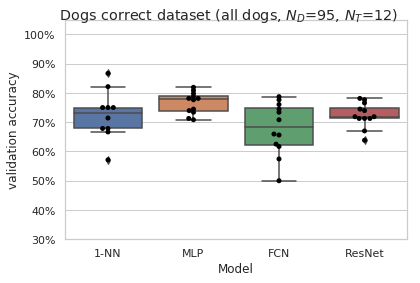

In [10]:
all_data = list()
all_end_test_data = list()
all_names = list()
results = []
end_test_results = []
N = dataset_size('private_correct_plus')
ND, NT, num_text = sample_sizes(N, k=3, m=4, brackets=False) 

file = '../../logs/2019-07-09T15:56/private_correct_plus/nearestneighbours_summary.csv' # 1-NN, instant
data = pd.read_csv(file, header=None, names=['val_acc', 'end_test_acc'])
all_data.append(data['val_acc'])
all_end_test_data.append(data['end_test_acc'])
all_names.append('1-NN')
results.append([all_names[-1], all_data[-1].mean(), all_data[-1].std()])
end_test_results.append([all_names[-1], all_end_test_data[-1].mean(), all_end_test_data[-1].std()])

file = '../../logs/2019-07-07T17:40/private_correct_plus/devnet_summary.csv' # MLP Wang 1h10m
data = pd.read_csv(file, header=None, names=['run','loss','val_acc','epoch','time', 'end_test_acc'])
all_data.append(data['val_acc'])
all_end_test_data.append(data['end_test_acc'])
all_names.append('MLP')
results.append([all_names[-1], all_data[-1].mean(), all_data[-1].std()])
end_test_results.append([all_names[-1], all_end_test_data[-1].mean(), all_end_test_data[-1].std()])

file = '../../logs/2019-07-08T16:49/private_correct_plus/devnet_summary.csv' # FCN 1h15m
data = pd.read_csv(file, header=None, names=['run','loss','val_acc','epoch','time', 'end_test_acc'])
all_data.append(data['val_acc'])
all_end_test_data.append(data['end_test_acc'])
all_names.append('FCN')
results.append([all_names[-1], all_data[-1].mean(), all_data[-1].std()])
end_test_results.append([all_names[-1], all_end_test_data[-1].mean(), all_end_test_data[-1].std()])

file = '../../logs/2019-07-07T20:52/private_correct_plus/devnet_summary.csv' # ResNet Wang, 12h30m
data = pd.read_csv(file, header=None, names=['run','loss','val_acc','epoch','time', 'end_test_acc'])
all_data.append(data['val_acc'])
all_end_test_data.append(data['end_test_acc'])
all_names.append('ResNet')
results.append([all_names[-1], all_data[-1].mean(), all_data[-1].std()])
end_test_results.append([all_names[-1], all_end_test_data[-1].mean(), all_end_test_data[-1].std()])

print(results)
plot_acc(all_data, all_names, '\tDogs correct dataset (all dogs, '+num_text+')', 'pubmodels_alldogs_correct.png')

## Test on realistic data
Lower sample standard deviation on this test set than on all_dogs correct dataset most likely because the test set itself is constant. Whereas, the validation set under k-fold cross validation changes with each iteration of model trainig.

[['1-NN', 0.6168831168831169, 0.006122136633649777], ['MLP', 0.6515151441666667, 0.02419108204701231], ['FCN', 0.5876623375, 0.06537630889626803], ['ResNet', 0.6233766083333334, 0.03735370168712767]]


Text(0.5, 25.959999999999994, 'Model (trained on dogs correct data)')

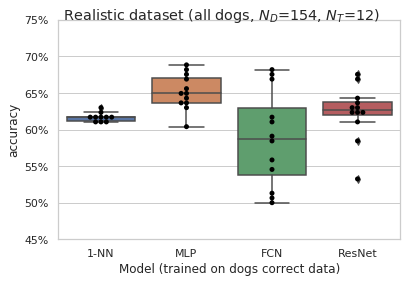

In [11]:
print(end_test_results)
title = '\tRealistic dataset (all dogs, $N_D$='+str(end_test_dataset_size('private_correct_plus'))
title = title + ', $N_T$='+NT+')'
ax, plt = plot_acc(all_end_test_data, all_names, title, 'pubmodels_alldogs_realistic.png', 'accuracy', ylim=[0.45,0.75])
ax.set_xlabel('Model (trained on dogs correct data)')

# Untuned MLP : dogs correct  : personal vs impersonal model

[['dog0\n$N_D$=34', 0.811274508635203, 0.03856976518499614], ['dog1\n$N_D$=25', 0.8782051205635071, 0.05347511261607151], ['dog2\n$N_D$=35', 0.6670751621325811, 0.05106223263639201], ['all dogs\n$N_D$=95', 0.7659389774004618, 0.03693851593866594]]


Text(0.5, 25.95999999999998, 'Dog correct dataset')

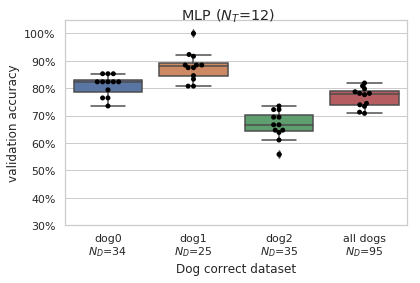

In [43]:
# TODO finish this one
all_data = list()
all_end_test_data = list()
all_names = list()
results = []
end_test_results = []
k = 3
m = 4
N = dataset_size('private_correct_plus')
ND, NT, num_text = sample_sizes(N, k, m, brackets=False) 

file = '../../logs/2019-07-12T14:41/private_dog0_correct_plus/devnet_summary.csv' 
data = pd.read_csv(file, header=None, names=['run','loss','val_acc','epoch','time', 'end_test_acc'])
all_data.append(data['val_acc'])
all_end_test_data.append(data['end_test_acc'])
ND, __, __ = sample_sizes(dataset_size('private_dog0_correct_plus'), k, m)
all_names.append('dog0\n$N_D$='+str(ND))
results.append([all_names[-1], all_data[-1].mean(), all_data[-1].std()])
end_test_results.append([all_names[-1], all_end_test_data[-1].mean(), all_end_test_data[-1].std()])

file = '../../logs/2019-07-12T17:23/private_dog1_correct_plus/devnet_summary.csv' 
data = pd.read_csv(file, header=None, names=['run','loss','val_acc','epoch','time', 'end_test_acc'])
all_data.append(data['val_acc'])
all_end_test_data.append(data['end_test_acc'])
ND, __, __ = sample_sizes(dataset_size('private_dog1_correct_plus'), k, m)
all_names.append('dog1\n$N_D$='+str(ND))
results.append([all_names[-1], all_data[-1].mean(), all_data[-1].std()])
end_test_results.append([all_names[-1], all_end_test_data[-1].mean(), all_end_test_data[-1].std()])

file = '../../logs/2019-07-12T18:34/private_dog2_correct_plus/devnet_summary.csv' 
data = pd.read_csv(file, header=None, names=['run','loss','val_acc','epoch','time', 'end_test_acc'])
all_data.append(data['val_acc'])
all_end_test_data.append(data['end_test_acc'])
ND, __, __ = sample_sizes(dataset_size('private_dog2_correct_plus'), k, m)
all_names.append('dog2\n$N_D$='+str(ND))
results.append([all_names[-1], all_data[-1].mean(), all_data[-1].std()])
end_test_results.append([all_names[-1], all_end_test_data[-1].mean(), all_end_test_data[-1].std()])

file = '../../logs/2019-07-07T17:40/private_correct_plus/devnet_summary.csv' 
data = pd.read_csv(file, header=None, names=['run','loss','val_acc','epoch','time', 'end_test_acc'])
all_data.append(data['val_acc'])
all_end_test_data.append(data['end_test_acc'])
ND, __, __ = sample_sizes(dataset_size('private_correct_plus'), k, m)
all_names.append('all dogs\n$N_D$='+str(ND))
results.append([all_names[-1], all_data[-1].mean(), all_data[-1].std()])
end_test_results.append([all_names[-1], all_end_test_data[-1].mean(), all_end_test_data[-1].std()])

print(results)
title = '\tMLP ($N_T$='+NT+')'
ax, plt = plot_acc(all_data, all_names, title, 'MLP_personal.png')
ax.set_xlabel('Dog correct dataset')

[['dog0\n$N_D$=34', 0.6716666666666665, 0.027579087378048966], ['dog1\n$N_D$=25', 0.7283950583333333, 0.02883330042737705], ['dog2\n$N_D$=35', 0.5902777783333333, 0.06900110622253293], ['all dogs\n$N_D$=95', 0.6515151441666667, 0.02419108204701231]]


Text(0.5, 25.95999999999998, 'Realistic dataset')

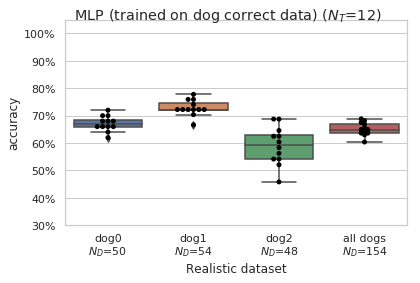

In [41]:
print(end_test_results)
all_names = list()

ND = end_test_dataset_size('private_dog0_correct_plus')
all_names.append('dog0\n$N_D$='+str(ND))
ND = end_test_dataset_size('private_dog1_correct_plus')
all_names.append('dog1\n$N_D$='+str(ND))
ND = end_test_dataset_size('private_dog2_correct_plus')
all_names.append('dog2\n$N_D$='+str(ND))
ND = end_test_dataset_size('private_correct_plus')
all_names.append('all dogs\n$N_D$='+str(ND))


title = '\tMLP (trained on dog correct data) ($N_T$='+NT+')'
ax, plt = plot_acc(all_end_test_data, all_names, title, 'MLP_personal_realistic.png.png', 'accuracy')
ax.set_xlabel('Realistic dataset')

# Dog accuracy

dog_result   FN  FP   TN   TP  All
dog                               
Furby        42  13   95   68  218
Ozzy         35  12   92   53  192
Sye          45  13   87   69  214
All         122  38  274  190  624
dog_result  Accuracy       TPR       TNR       FPR       FNR
dog                                                         
Furby       0.747706  0.618182  0.879630  0.120370  0.381818
Ozzy        0.755208  0.602273  0.884615  0.115385  0.397727
Sye         0.728972  0.605263  0.870000  0.130000  0.394737
All         0.743590  0.608974  0.878205  0.121795  0.391026


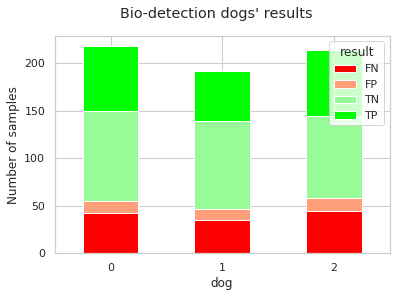

In [13]:
datadir = '../../data/private_data/private_events_dev2' 
fname = 'private_balanced'
meta_train = pd.read_csv(datadir+'/'+fname+'/'+fname+'_TRAIN_meta.txt', sep=',', parse_dates=['date'])
meta_test = pd.read_csv(datadir+'/'+fname+'/'+fname+'_TEST_meta.txt', sep=',', parse_dates=['date'])
meta = pd.concat([meta_train, meta_test])

colors = ['red', 'lightsalmon', 'palegreen', 'lime' ]   
meta.groupby('dog')['dog_result'] \
    .value_counts() \
    .sort_index(ascending=False) \
    .unstack(level=1) \
    .plot.bar(stacked=True, color=colors)

plt.xticks([0, 1, 2], ['0', '1', '2'])
plt.xticks(rotation=0)
plt.ylabel('Number of samples')
plt.suptitle('Bio-detection dogs\' results')
plt.legend(title='result')
plt.savefig('bar_dogAccuracy.png', bbox_inches='tight')

results = meta.pivot_table('run', index='dog', columns='dog_result', aggfunc=len, fill_value=0, margins=True)
print(results)


# Calculate Accuracy and FNR, false negative rate, etc.
P = results.TP+results.FN
N = results.TN+results.FP
results['Accuracy'] = (results.TP+results.TN)/(P+N)
results['TPR'] = results.TP/P
results['FPR'] = results.FP/N
results['TNR'] = results.TN/N
results['FNR'] = results.FN/P
print(results[['Accuracy', 'TPR', 'TNR', 'FPR', 'FNR']])

# MLP hyperparameter tuning

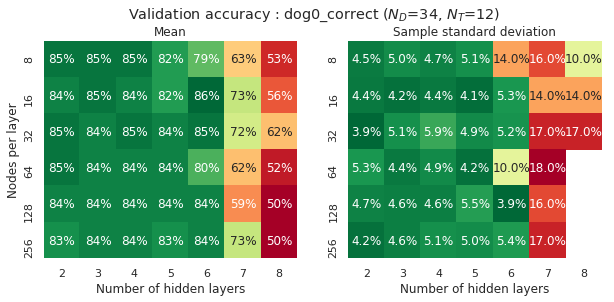

In [14]:
ND, NT, num_text = sample_sizes(dataset_size('private_dog0_correct_plus'), k=3, m=4)

acc = [[ 0.85,0.85, 0.85, 0.82, 0.79, 0.63, 0.53],
        [0.84,0.85, 0.84, 0.82, 0.86, 0.73, 0.56],
        [0.85,0.84, 0.85, 0.84, 0.85, 0.72, 0.62],
        [0.85,0.84, 0.84, 0.84, 0.8, 0.62, 0.52],
        [0.84,0.84, 0.84, 0.84, 0.84, 0.59, 0.5],
        [0.83,0.84, 0.84, 0.83, 0.84, 0.73, 0.5]]

std = [[ 0.045,0.05, 0.047, 0.051, 0.14, 0.16, 0.1],
        [0.044,0.042, 0.044, 0.041, 0.053, 0.14, 0.14],
        [0.039,0.051, 0.059, 0.049, 0.052, 0.17, 0.17],
        [0.053,0.044, 0.049, 0.042, 0.1, 0.18,  np.nan],
        [0.047,0.046, 0.046, 0.055, 0.039, 0.16,  np.nan],
        [0.042,0.046, 0.051, 0.05, 0.054, 0.17,  np.nan]]

fig = plt.figure(figsize=(10, 4))
ax0 = fig.add_subplot(121)
ax1 = fig.add_subplot(122, sharey=ax0)
sns.heatmap(acc, cmap='RdYlGn', annot=True, fmt = '.0%', cbar=False, ax=ax0)
sns.heatmap(std, cmap='RdYlGn_r', annot=True, fmt = '.1%', cbar=False, ax=ax1)
ax0.set_xlabel('Number of hidden layers')
ax1.set_xlabel('Number of hidden layers')
ax0.set_ylabel('Nodes per layer')
ax0.set_xticklabels([2, 3, 4, 5, 6, 7, 8])
ax1.set_xticklabels([2, 3, 4, 5, 6, 7, 8])
ax0.set_yticklabels([8, 16, 32, 64, 128, 256])
ax0.set_title('Mean')
ax1.set_title('Sample standard deviation')
title = 'Validation accuracy : dog0_correct '+num_text
plt.suptitle(title, y=1)     
plt.savefig('heatmap_MLP_dog0Correct.png', bbox_inches='tight')

# Tuned models : trained on all dogs correct dataset

In [81]:
def append_result_set(file, name, all_data, all_end_test_data, all_names, results):
    data = pd.read_csv(file, header=None, names=['run','loss','val_acc','epoch','time', 'end_test_acc'])
    all_data.append(data['val_acc'])
    all_end_test_data.append(data['end_test_acc'])
    all_names.append(name)
    results.append([all_names[-1], data['val_acc'].mean(), data['val_acc'].std(), 
                data['end_test_acc'].mean(), data['end_test_acc'].std()])

,set,val_acc,val_std,end_acc,end_std
0,MLP tuned,0.830231,0.024279,0.699134,0.012175
1,FCN tuned,0.731512,0.068200,0.640152,0.059350
2,ResNetntuned,0.784371,0.033509,0.687771,0.023892
3,CNN tuned,0.770279,0.036947,0.686147,0.016459


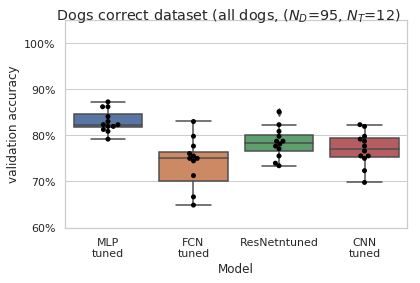

In [82]:
all_data = list()
all_end_test_data = list()
all_names = list()
results = []
end_test_results = []
N = dataset_size('private_correct_plus')
ND, NT, num_text = sample_sizes(N, k=3, m=4) 

# Get results sets
file = '../../logs/2019-05-11T19:09/private_correct_plus/devnet_summary.csv' 
append_result_set(file, 'MLP\ntuned', all_data, all_end_test_data, all_names, results)

file = '../../logs/2019-07-12T08:47/private_correct_plus/devnet_summary.csv' # FCN TODO - tune it more
append_result_set(file, 'FCN\ntuned', all_data, all_end_test_data, all_names, results)

file = '../../logs/2019-07-12T06:35/private_correct_plus/devnet_summary.csv' # ResNet 
append_result_set(file, 'ResNetntuned', all_data, all_end_test_data, all_names, results)

file = '../../logs/2019-07-12T05:31/private_correct_plus/devnet_summary.csv' # CNN
append_result_set(file, 'CNN\ntuned', all_data, all_end_test_data, all_names, results)

# Plot
save_filename = 'tuned_alldogs_correct'
plot_acc(all_data, all_names, '\tDogs correct dataset (all dogs, '+num_text, save_filename+'.png', ylim=[0.6, 1.05])
res = pd.DataFrame(results, columns=['set', 'val_acc', 'val_std', 'end_acc', 'end_std'])
res = res.replace(to_replace=r'\n', value=' ', regex=True)
res.to_csv(save_filename+'.csv')
res

(<matplotlib.axes._subplots.AxesSubplot at 0x7f551bcfbe80>,
 <module 'matplotlib.pyplot' from '/usr/local/lib/python3.5/dist-packages/matplotlib/pyplot.py'>)

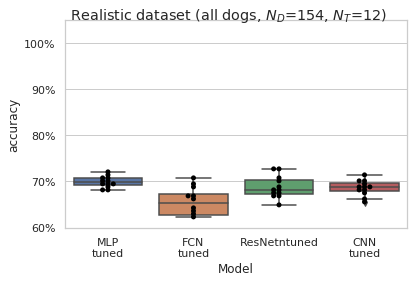

In [83]:
title = '\tRealistic dataset (all dogs, $N_D$='+str(end_test_dataset_size('private_correct_plus'))
title = title + ', $N_T$='+NT+')'
plot_acc(all_end_test_data, all_names, title, 'tuned_alldogs_realistic.png', 'accuracy', ylim=[0.6, 1.05])

# Confusion matrices

acc 0.70779221 dog_acc 0.7597402597402597 ND 154


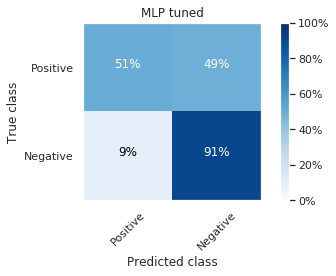

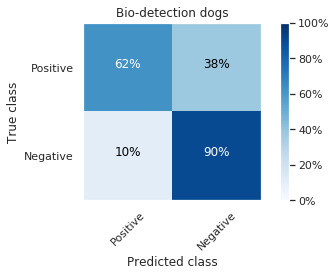

In [17]:
''' As per end test on MLP 1000/16/16/16/1
../logs/2019-05-12T16:36/private_correct_plus/devnet_summary.csv
[[39 38]
 [ 7 70]]
Class balance in test set: 77 to 77 i.e. 0.5
'''
cm = np.array(  [[0.50649351, 0.49350649],
                 [0.09090909, 0.90909091]])
acc = (cm[0][0]+cm[1][1])/(cm.sum())
plot_confusion_matrix(cm, title='MLP tuned', name='cm_MLPtuned_endTest')


dog_cm = np.array([[48, 29],
                    [8, 69]])
dog_acc = (dog_cm[0][0]+dog_cm[1][1])/(dog_cm.sum())
ND = dog_cm.sum()
dog_cm = dog_cm.astype('float') / dog_cm.sum(axis=1)[:, np.newaxis]
plot_confusion_matrix(dog_cm, title='Bio-detection dogs', name='cm_dog_endTest')

print('acc', acc, 'dog_acc', dog_acc, 'ND', ND)

acc 0.70779221


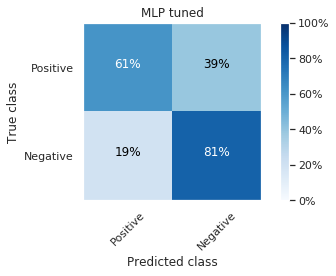

In [18]:
''' With probability threshold 0.3
[[47 30]
 [15 62]]
Calculated accuracy: 0.7077922077922078
'''  
cm = np.array([[0.61038961, 0.38961039],
               [0.19480519, 0.80519481]])
plot_confusion_matrix(cm, title='MLP tuned', name='cm_MLPtuned_endTest_threshold_0.3')
print('acc', (cm[0][0]+cm[1][1])/(cm.sum()))

# Dataset size vs accuracy
MLP 16/16/16

[ 17.  20.  27.  33.  40.  47.  50.  53.  60.  67.  68.  83. 100. 117.
 133. 150. 167. 183. 189.]
[ 8. 10. 13. 17. 20. 23. 25. 27. 30. 33. 34. 42. 50. 58. 67. 75. 83. 92.
 95.]


Text(0, 0.5, 'Mean validation accuracy')

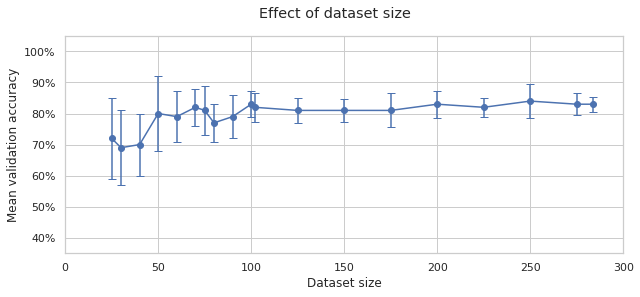

In [19]:
x = np.array([25,30,40,50,60,70,75,80,90,100,102,125,150,175,200,225,250,275,284])
mean_acc = [0.72,0.69,0.7,0.8,0.79,0.82,0.81,0.77,0.79,0.83,0.82,0.81,0.81,0.81,0.83,0.82,0.84,0.83,0.83]
acc_std = [0.13,0.12,0.1,0.12,0.082,0.059,0.08,0.062,0.07,0.042,0.046,0.04,0.036,0.055,0.044,0.03,0.055,0.035,0.024]


k = 3
x_train = np.round((x/k*(k-1)))
x_test = x-x_train

print(x_train)
print(x_test)

yerr = [acc_std, acc_std]
fig, ax = plt.subplots(figsize=(10, 4))
ax.errorbar(x, mean_acc, yerr,fmt='-o', capsize=4)

ax.set_ylim(bottom=0.35, top=1.05)
ax.set_xlim(left=0, right=300)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0, 0))
plt.suptitle('Effect of dataset size')
ax.set_xlabel('Dataset size')
ax.set_ylabel('Mean validation accuracy')

Train on 189.0 acc 0.7 std 0.012
Train on 68.0 acc 0.7 std 0.015


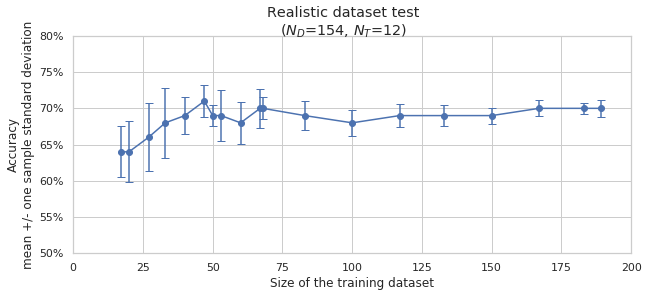

In [20]:
end_test_acc = [0.64,0.64,0.66,0.68,0.69,0.71,0.69,0.69,0.68,0.7,0.7,0.69,0.68,0.69,0.69,0.69,0.7,0.7,0.7]
end_test_std = [0.035,0.042,0.047,0.048,0.025,0.022,0.015,0.035,0.029,0.027,0.015,0.02,0.018,0.016,0.014,0.011,0.011,0.008,0.012]

yerr = [end_test_std, end_test_std]
fig, ax = plt.subplots(figsize=(10, 4))
ax.errorbar(x_train, end_test_acc, yerr,fmt='-o', capsize=4)

ax.set_ylim(bottom=0.5, top=0.8)
ax.set_xlim(left=0, right=200)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0, 0))
num_text = '($N_D$='+str(154)+', $N_T$='+str(12)+')'
plt.suptitle('Realistic dataset test\n'+num_text)
ax.set_xlabel('Size of the training dataset')
ax.set_ylabel('Accuracy\nmean +/- one sample standard deviation')

print('Train on', x_train[-1], 'acc', end_test_acc[-1], 'std', end_test_std[-1])
print('Train on', x_train[10], 'acc', end_test_acc[10], 'std', end_test_std[10])